Current working directory: /Users/antonstepanyan/Desktop/RL/Reinforcement-Learning/counter-examples
Folders: ['.DS_Store', 'generated_images', 'README.md', '.git', 'notebooks', '.idea', 'src']
Final emphasis value: 100.0000
Final RMSVE: 0.000000
Final RMSPBE: 0.000000
Data lengths -> iters: 500 emphasis: 500 RMSVE: 500 RMSPBE: 500


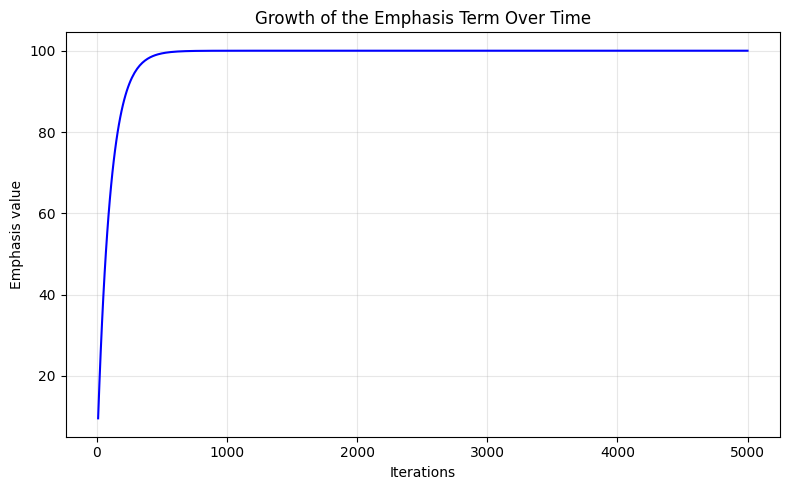

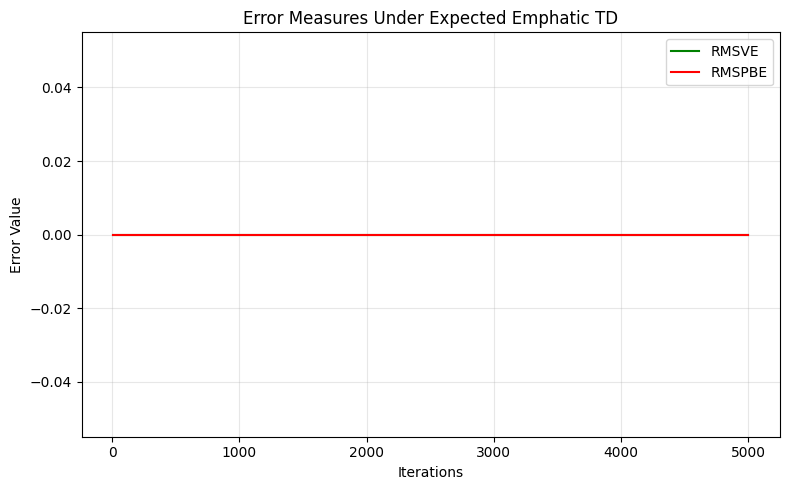

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import os

# change working directory to the folder where your notebooks are
os.chdir("/Users/antonstepanyan/Desktop/RL/Reinforcement-Learning/counter-examples")  # <--- your real path here

# make sure the folder exists
os.makedirs("generated_images", exist_ok=True)

print("Current working directory:", os.getcwd())
print("Folders:", os.listdir())

# --- MDP and feature setup ---

states = np.arange(0, 7)
lower_state = 6

discount = 0.99
feature_vector_size = 8

features = np.zeros((len(states), feature_vector_size))

# Upper states: each has its own active feature and a shared last feature
for i in range(len(states) - 1):
    features[i, i] = 2.0
    features[i, feature_vector_size - 1] = 1.0

# Lower state: uses the last two features
features[lower_state, feature_vector_size - 2] = 1.0
features[lower_state, feature_vector_size - 1] = 2.0

actions = {"dashed": 0, "solid": 1}

reward = 0.0
behavior_solid_probability = 1.0 / 7.0

state_distribution = np.ones(len(states)) / len(states)
state_distribution_matrix = np.diag(state_distribution)

projection_matrix = (
    features
    @ np.linalg.pinv(features.T @ state_distribution_matrix @ features)
    @ features.T
    @ state_distribution_matrix
)

interest = 1.0


# --- Error metrics ---

def compute_RMSVE(weights: np.ndarray) -> float:
    """Root Mean Squared Value Error under the behavior state distribution."""
    approx_values = features @ weights
    squared_errors = approx_values ** 2  # true value is 0 for all states
    ms_ve = np.dot(squared_errors, state_distribution)
    return np.sqrt(ms_ve)


def compute_RMSPBE(weights: np.ndarray) -> float:
    """Root Mean Squared Projected Bellman Error under the behavior distribution."""
    bellman_errors = np.zeros(len(states))

    for s in states:
        for next_state in states:
            if next_state == lower_state:
                bellman_errors[s] += (
                    reward
                    + discount * np.dot(weights, features[next_state, :])
                    - np.dot(weights, features[s, :])
                )

    projected_be = projection_matrix @ bellman_errors
    squared_errors = projected_be ** 2
    ms_pbe = np.dot(squared_errors, state_distribution)
    return np.sqrt(ms_pbe)


# --- Expected Emphatic TD ---

def expected_emphatic_TD(weights: np.ndarray, emphasis: float, step_size: float):
    """
    Expected Emphatic TD update for this example.
    Returns the updated weights and the expected next emphasis value.
    """
    total_update = 0.0
    total_next_emphasis = 0.0

    for s in states:
        # Importance sampling ratio: only non-zero at lower_state
        if s == lower_state:
            rho = 1.0 / behavior_solid_probability
        else:
            rho = 0.0

        # Emphasis update
        next_emphasis = discount * rho * emphasis + interest
        total_next_emphasis += next_emphasis

        # TD error assuming next state is always lower_state
        td_error = (
            reward
            + discount * np.dot(features[lower_state, :], weights)
            - np.dot(weights, features[s, :])
        )

        state_prob = 1.0 / len(states)

        total_update += (
            state_prob
            * behavior_solid_probability
            * next_emphasis
            * rho
            * td_error
            * features[lower_state, :]
        )

    weights += step_size * total_update
    avg_next_emphasis = total_next_emphasis / len(states)
    return weights, avg_next_emphasis


# --- Experiment ---

num_iterations = 5_000
step_size = 0.05

w = np.zeros(feature_vector_size)
emphasis = 0.0

emphasis_history = []
rmsve_history = []
rmspbe_history = []

for t in range(num_iterations):
    w, emphasis = expected_emphatic_TD(w, emphasis, step_size)

    if (t + 1) % 10 == 0:
        emphasis_history.append(emphasis)
        rmsve_history.append(compute_RMSVE(w))
        rmspbe_history.append(compute_RMSPBE(w))

# Display final metrics
print(f"Final emphasis value: {emphasis_history[-1]:.4f}")
print(f"Final RMSVE: {rmsve_history[-1]:.6f}")
print(f"Final RMSPBE: {rmspbe_history[-1]:.6f}")

# Generate iteration index for plotting
iters = np.arange(10, num_iterations + 1, 10)

# Safety check to confirm matching lengths
print("Data lengths ->",
      "iters:", len(iters),
      "emphasis:", len(emphasis_history),
      "RMSVE:", len(rmsve_history),
      "RMSPBE:", len(rmspbe_history))

# Ensure the output directory exists
import os
os.makedirs("generated_images", exist_ok=True)

# -------------------------------
# Plot 1 — Emphasis Evolution
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(iters, emphasis_history, color="blue")
plt.xlabel("Iterations")
plt.ylabel("Emphasis value")
plt.title("Growth of the Emphasis Term Over Time")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("generated_images/emphasis_over_time.png", dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------
# Plot 2 — RMSVE & RMSPBE Curves
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(iters, rmsve_history, label="RMSVE", color="green")
plt.plot(iters, rmspbe_history, label="RMSPBE", color="red")
plt.xlabel("Iterations")
plt.ylabel("Error Value")
plt.title("Error Measures Under Expected Emphatic TD")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("generated_images/emphatic_td_errors.png", dpi=300, bbox_inches='tight')
plt.show()
